In [1]:
import re
import os
import json
import networkx as nx
from collections import Counter
import datetime
import matplotlib.pyplot as plt

In [2]:
def get_date(s):
    return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')


names            = [line.strip() for line in open('Ikon/extracted/all_artists_raw.dat')]
original2cleaned = {n : n.replace(',\n', '') for n in names}
names_cnt        = {line.split('\t')[0] : float(line.strip().split('\t')[1]) for line in open('Ikon/extracted/all_artists_cnt.dat') if len(line.strip().split('\t')) == 2}

names_first = {}
names_last  = {}

for line in open('Ikon/extracted/names_min_max_date.dat'):
    fields = line.strip().split('\t')
    if len(fields) == 3: 
        n, t1, t2 = fields
        names_first[n] = get_date(t1)
        names_last[n]  = get_date(t2)
        
        
print('Number of unique artist names: ', len(names), len(names_last), len(names_first))

names_with_dates  = set(names_last.keys())
names_with_issues = set(names).difference(names_with_dates)

len(names_with_issues)

Number of unique artist names:  27498 27496 27496


3

### First stage: replace and drop things that are obvisouly not ok

In [3]:
# replace these by ''
to_replace = [
    '..',
    '-,',
    '-', ';', '.', '/', '?', '*', '!', '+',
    ';.',
    '"', 
    ')',
    '(',
    ',', 'művészettörténész', 'plakátművész', 'kortárs művész', 'résztvevő', 'résztvevők', 
    'képzőművész', ' művész', ' alkotó', 'filmesztéta', 'építész'
    ]



# drop names that contain these
to_drop = [
    '2000',
    '100'
    ]

In [4]:
cleaned2original = {}
        
for original, cleaned in original2cleaned.items(): 
  
    todrop = False
    
    cleaned = cleaned.lower()

    for tr in to_replace:
        cleaned = cleaned.replace(tr, '')

    for td in to_drop:
        if td in original:
            todrop = True
            break
 
            
    cleaned = cleaned.rstrip().strip()
    if not todrop and len(cleaned) > 1:

        original2cleaned[original] = cleaned
        cleaned2original[cleaned]  = original
    
      
#for ind, (c, o) in enumerate(cleaned2original.items()):
#    if ind == 5: break
#    print(o.strip(), '\t', c)
    
    
print('\nNumber of unique artist names: ', len(names))
print('Number of artist names after first filter: ', len(cleaned2original.keys()))


Number of unique artist names:  27498
Number of artist names after first filter:  22698


In [5]:
fout = open('Ikon/extracted/all_names_precleaned.dat', 'w')
cleaned = sorted(list(set(original2cleaned.values())))

print(len(cleaned))
for c in cleaned:
    fout.write(c + '\n')
fout.close()

22772


In [6]:
cleaned

['',
 '&#183\tfekete zoltán videoinstallációja',
 '&#213excellenciája dimitris contoumas úr',
 '&#8222biciklis közműtárgy&#8221 kiállítás madárijesztőrémísztő kiállítás',
 '&aringsa sonjasdottír',
 ')+-(,',
 '),',
 '*',
 '***,',
 '*,',
 ',',
 '-',
 '-,',
 '--',
 '--,',
 '---',
 '---,',
 '-----',
 '.',
 '.,',
 '..',
 '..,',
 '...',
 '...,',
 '.........,',
 '.................',
 '...................................,',
 '0',
 '0205 > 0228',
 '0:00  mike nylons  live',
 '1 kis csokolom koncert',
 '10 horvát és magyar mezogazdász család közremuködésével',
 '10 lengyel',
 '100 hazai és külföldi művész,',
 '100 kortárs művész részvételével,',
 '100 kortárs művész,',
 '100 képzőművész',
 '100 világhírű plakátművész,',
 '1000%,',
 '110 mìvész  21 országból',
 '12z_live act',
 '135',
 '14',
 '145',
 '15 oratol  julien saglio: leveskomozicio',
 '18  2000 óra',
 '18 artcamp',
 '18 óra timár katalin',
 '18 órától',
 '19',
 '19 projekt',
 '19 év alatti fiatalok számítógépes versenye',
 '19 óra galap

### Second stage: group the simialr names together

Let's do pairwise comparison between the name strings to catch different forms of the same name

Number of pairs above similarity score 64:  2224032


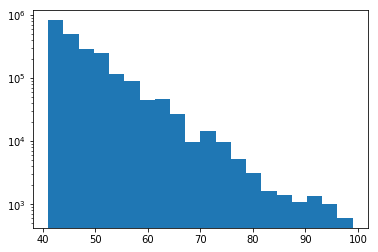

In [325]:
# pairwise comparison of all the names and computing their similarity
# by https://pypi.org/project/Fuzzy/

pairs_similarities = []

files = os.listdir('Ikon/name_matching')
sims  = []

for fn in files:  
    with open('Ikon/name_matching/' + fn) as f:
        next(f)
        for line in f:
            n1, n2, score = line.strip().split('\t')
            pairs_similarities.append((n1, n2, float(score)))  
            sims.append(float(score))
 
print('Number of pairs above similarity score 64: ', len(sims))

plt.hist(sims, bins = 20)
plt.yscale('log')

#### weighting based on frequency

In [329]:
similarity_limit = 90

print(len([s for _, _, s in pairs_similarities if s > similarity_limit]))

for ind, (n1, n2, score) in enumerate(pairs_similarities):

    if score > similarity_limit:
        a = 2
        #print(score, '\t', n1, '\t', n2)       

2990


#### filtering based on temporal overlaps

Seems that 80 does not give a perfect threshold, there are mismatches but still similar enough. Let's add the time of the first and last exhibition of these individuals as features as well and see if they overlap are close enough. I also add the number of times the different variants have occurred, and the less frequent as a modified version of the more frequent if the latter occurred at least X times more often.

In [251]:
#def intervals_overlap(s1, s2, e1, e2, delay):

def getOverlap(a, b):
    return abs((min(a[1], b[1]) - max(a[0], b[0])).days)


delay_limit = 2*365

for n1, n2, s in pairs_similarities[50:250]:
    
    if s > 150:

        start1 = names_first[cleaned2original[n1].strip()]
        start2 = names_first[cleaned2original[n2].strip()]
                
        end1 = names_last[cleaned2original[n1].strip()]
        end2 = names_last[cleaned2original[n2].strip()]        
        
        cnt1 = names_cnt[cleaned2original[n1]]
        cnt2 = names_cnt[cleaned2original[n2]]        
        
        delay = getOverlap([start1, end1], [start2, end2])
        
        #print(delay)
        if delay > delay_limit:
            print('More than ', delay_limit, ' days of delay (', delay_limit ,')')

        #print(start1, end1)
        #print(start2, end2)
        
        print(n1, cnt1, '\t', n2, cnt2, '\n')
        
        

It seems that e.g. in the case of Vízy and Csízy, the year-filtering is needed. However, Vízy, Vitézy, and Csízy seem to belong to the same similarity cluster, so pairwise comparisond and replacements may not be efficeient. Lets build a similarity graph!

#### building similarity graph components

In [334]:
G = nx.Graph()

delay_limit      = 10*365
similarity_limit = 90
frequency_limit  = 2
total_weight     = 5
off = 1

nodes = set()

for n1, n2, s in pairs_similarities:
    nodes.add(n1)
    nodes.add(n2)
    if s > similarity_limit:
        
        #print(n1, cleaned2original[n1])

        #start1 = names_first[cleaned2original[n1].strip()]
        #start2 = names_first[cleaned2original[n2].strip()]
        
        ##end1 = names_last[cleaned2original[n1].strip()]
        #end2 = names_last[cleaned2original[n2].strip()]        
        try:
            cnt1 = names_cnt[cleaned2original[n1]]
            cnt2 = names_cnt[cleaned2original[n2]] 
            G.add_edge(n1, n2, weight = s)
        except:
            off += 1
            pass
        
        #delay = getOverlap([start1, end1], [start2, end2])
    
        #if delay < delay_limit:
        

print('Number of edges: ', len(G.edges))
print('OFF: ', off)

components = sorted(nx.connected_components(G), key=len, reverse=True)

print('Number of similarity clusters: ', len(components))

names_replace = {}

for c in components:  
    component_weight = sum([names_cnt[cleaned2original[cc]] for cc in c])
    if component_weight >= total_weight: 
    
        comps = sorted(list([(cc, names_cnt[cleaned2original[cc]]) for cc in c]), key = lambda tup: tup[1], reverse = True)
        main  = comps[0][0]
        
        #print(comps)
        
        for r in comps[1:]:
            names_replace[r[0]] = main

      

#print('Number of components', len(components))
#len([line.strip() for line in open('Ikon/extracted/all_artists_raw.dat')])

Number of edges:  1482
OFF:  27
Number of similarity clusters:  1136


In [335]:
print(len(list(nodes)))
      
nodes_c = []
for n in list(nodes):
    if n in names_replace:
        nodes_c.append(names_replace[n])
    else:
        nodes_c.append(n)
        
len(nodes_c), len(set(nodes_c))

22666


(22666, 21790)

In [227]:
for c, o in cleaned2original.items():
    if 'zákányi' in c:
        print((c, o))

('zákányi péter ', 'Zákányi Péter művészettörténész')


### Frequency distribution

In [91]:
for c, o in cleaned2original.items():
    if 'MAROSI' in c:
        print(c)

DANZIGER Dániel    HENDZSEL Ilona    HERBSZT László    KÁNVÁSI Krisztián    MAROSI Károly    RIDOVICS András    ROTH Péter    Lidija SKENDEROVIC    SZÉP Hedvig      KOVÁCS Zoltán    Noémi Regina CSERGÔ    NAGY Gergő    KERESZTÚRI Kata    NAGY Júlia    ORB
